<a href="https://colab.research.google.com/github/fhfmendes04/HA_FJSSP/blob/main/HA_AG_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

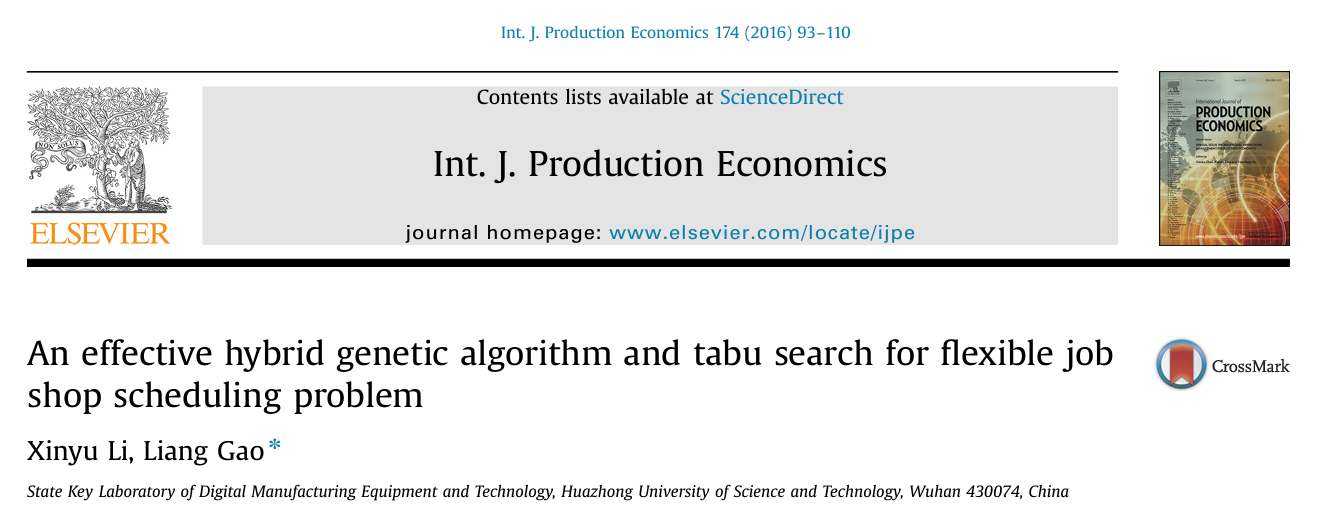

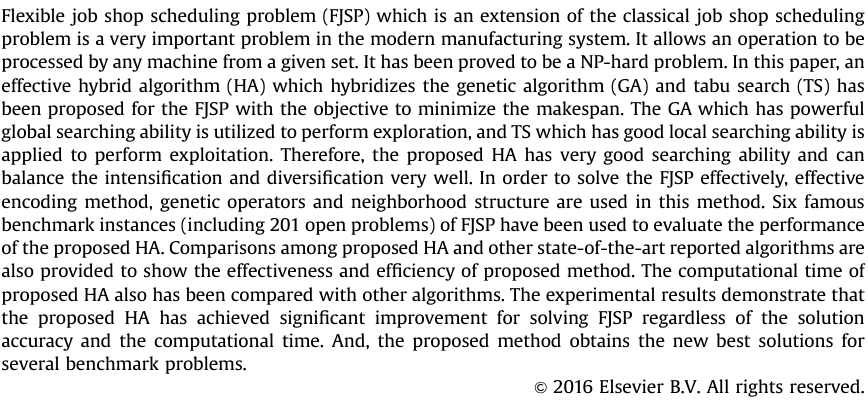

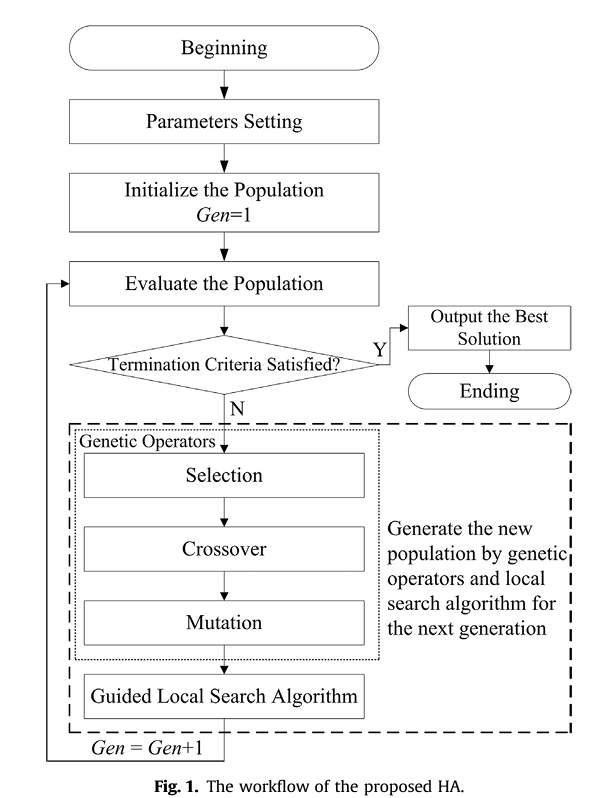

In [ ]:
Foi implementado para o experimento 2.



In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class individuo():
  def __init__(self, job, operation, machine, regras_MS):
    self.OS = []
    self.MS = []
    self.regras_MS = regras_MS

    self.job = job
    self.operation = operation
    self.machine = machine

    self.scheduling = []
    self.makespan = 0

    self.OS_String()
    self.MS_String()



  def OS_String(self):
    lista = [3,3,3,3,3,3,3,3,3,3,3,3]
    for l in range(0,self.job * self.operation):
      flag = True
      while flag:
        numero = random.randint(0,11)
        if lista[numero]>=0:
          lista[numero] -= 1
          self.OS.append(numero)
          flag=False

  def MS_String(self):
    for j in range(0, self.job):
      reg = self.regras_MS[j]
      for o in range(0, self.operation):
        self.MS.append(random.choice(reg[o]))

In [41]:
class HA_AG_TS():
  def __init__(self, tamanho_populacao=400, geracao=200, prob_reproduction = 0.2):
    self.tamanho_populacao = tamanho_populacao
    self.populacao = []
    self.geracao = geracao
    self.prob_reproduction = prob_reproduction
    self.lista_solucoes = []
    self.df = pd.DataFrame()
    self.job = 0
    self.operation = 0
    self.machine = 0
    self.regras_MS = []
    self.gen = 0
    self.pop_ordenada = []
    self.parents = []
    self.offsprings = []
    self.best = []
    self.tamanho =  0

    self.upload()
    self.regramento_MS()

  def upload(self):
      arquivo = "/content/drive/MyDrive/USP/Mestrado Sistema de Informação/SIN 5006 - Inteligência Computacional/Apresentação I/code/MFJS01.xlsx"
      self.df = pd.read_excel(arquivo, index_col=False)
      self.job = len(self.df['JOB'].unique())
      self.operation = len(self.df['OPERATION'].unique())
      self.machine = len(self.df['MACHINE'].unique())
      print("JOB: ", self.job)
      print("OPERATION: ", self.operation)
      print("MACHINE: ", self.machine)

      self.df.fillna(0,inplace=True)
      self.df["MACHINE.2"] = self.df["MACHINE.2"].astype(int)
      self.df['TIME.2'] = self.df["TIME.2"].astype(int)

  def regramento_MS(self):
    for j in range(0,self.job):
      regra_o = []
      dados = self.df[self.df["JOB"]==j].reset_index(drop=True)
      for o in range(0, self.operation):
        regra = []
        machine_1 = dados.iloc[o][3]
        machine_2 = dados.iloc[o][5]
        machine_3 = dados.iloc[o][7]

        if (machine_1 != 0):
          regra.append(machine_1)
        elif (machine_1 == 0):
          if (dados.iloc[0][4]!= 0):
            regra.append(machine_1)

        if(machine_2 != 0):
          regra.append(machine_2)
        elif (machine_2 == 0):
          if(dados.ilo[o][6] != 0):
            regra.append(machine_2)

        if(machine_3 !=0):
          regra.append(machine_3)
        elif (machine_3 == 0):
          if (dados.iloc[o][8] !=0):
            regra.append(machine_3)

        regra_o.append(regra)

      self.regras_MS.append(regra_o)

  def fitness(self,os_lista, ms_lista):
    maquinas = []
    controle_os = np.zeros(self.job) # Vetor para contar Operation.

    #Transforma a lista de 48 elementos em 12 x 4
    conta = 0
    mostra = []
    maquinas = []
    machine_job = [[0],[0],[0],[0],[0],[0],[0],[0]]
    job_time = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]

    for i in ms_lista: # Cria uma lista com as máquinas.
      mostra.append(i)
      conta +=1
      if ((conta % 4) == 0):
        conta = 0
        maquinas.append(mostra)
        mostra=[]
    #print(maquinas)

    for o in os_lista: # Por Posição na lista OS.
      posicao = int(controle_os[o]) # Descobre a Operation do JOB na Lista OS.
      controle_os[o] += 1
      #print(o,posicao, controle_os, maquinas[o][posicao])
      dados = self.df[self.df["JOB"]==o].reset_index(drop=True) # cria df
      localizador = maquinas[o][posicao] # Idenfica a MACHINE
      machine_1 = dados.iloc[posicao][3]
      machine_2 = dados.iloc[posicao][5]
      machine_3 = dados.iloc[posicao][7]

      #print(f"Operation: {o},  posicao: {posicao} - maquinas: {maquinas[o][posicao]}")

      if (machine_1 == localizador):
        if (dados.iloc[posicao][4] > 0):
          if (posicao == 0): # Primeira vez na machine
            machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(machine_job[localizador][0]) + "-" + str(machine_job[localizador][0] + dados.iloc[posicao][4]))
            machine_job[localizador][0] = machine_job[localizador][0] + dados.iloc[posicao][4] # Armazena o maior valor
            job_time[o] = machine_job[localizador][0] # armazena o tempo
            #print(machine_job[localizador])
          else:
              inicio = job_time[o]
              final = inicio + dados.iloc[posicao][4]
              #ultimo = final
              #print(f"inicio: {inicio}, final: {final}, ultimo: {ultimo}")
              flag = True
              while flag:
                conflito = 0
                tempo = []
                for m in range(1, len(machine_job[localizador])):
                  s = machine_job[localizador][m]
                  index_1 = s.find(":")
                  index_2 = s.find("-")
                  numero_1 = int(s[(index_1+1):index_2])
                  numero_2 = int(s[(index_2+1):])
                  if (inicio >= numero_1) and (inicio < numero_2):
                    conflito += 1
                    tempo.append(numero_2)
                  elif (inicio < numero_1) and (final >= numero_2):
                      conflito += 1
                      tempo.append(numero_2)
                  elif (final >= numero_1) and (final < numero_2):
                      conflito += 1
                      tempo.append(numero_2)

                if conflito == 0:
                  flag = False
                else:
                  inicio = min(tempo)
                  final = inicio + dados.iloc[posicao][4]


              machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(inicio) + "-" + str(final))
              if final > machine_job[localizador][0]:
                machine_job[localizador][0] = final
              job_time[o] = machine_job[localizador][0]
              #print(machine_job[localizador])

      else:
        if (machine_2 == localizador):
          if (dados.iloc[posicao][6] > 0):
            if (posicao == 0): # Primeira vez na machine
              machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(machine_job[localizador][0]) + "-" + str(machine_job[localizador][0] + dados.iloc[posicao][4]))
              machine_job[localizador][0] = machine_job[localizador][0] + dados.iloc[posicao][4]
              job_time[o] = machine_job[localizador][0]
              #print(machine_job[localizador])
            else:
              inicio = job_time[o]
              final = inicio + dados.iloc[posicao][4]
              flag = True
              while flag:
                conflito = 0
                tempo = []
                for m in range(1, len(machine_job[localizador])):
                  s = machine_job[localizador][m]
                  index_1 = s.find(":")
                  index_2 = s.find("-")
                  numero_1 = int(s[(index_1+1):index_2])
                  numero_2 = int(s[(index_2+1):])
                  if (inicio >= numero_1) and (inicio < numero_2):
                    conflito += 1
                    tempo.append(numero_2)
                  elif (inicio < numero_1) and (final >= numero_2):
                      conflito += 1
                      tempo.append(numero_2)
                  elif (final >= numero_1) and (final < numero_2):
                      conflito += 1
                      tempo.append(numero_2)

                if conflito == 0:
                  flag = False
                else:
                  inicio = min(tempo)
                  final = inicio + dados.iloc[posicao][4]

              machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(inicio) + "-" + str(final))
              if final > machine_job[localizador][0]:
                machine_job[localizador][0] = final
              job_time[o] = machine_job[localizador][0]
              #print(machine_job[localizador])
        else:
          if (machine_3 == localizador):
            if (dados.iloc[posicao][8]>  0):
              if (posicao == 0): # Primeira vez na machine
                machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(machine_job[localizador][0]) + "-" + str(machine_job[localizador][0] + dados.iloc[posicao][4]))
                machine_job[localizador][0] = machine_job[localizador][0] + dados.iloc[posicao][4]
                job_time[o] = machine_job[localizador][0]
                #print(machine_job[localizador])
              else:
                inicio = job_time[o]
                final = inicio + dados.iloc[posicao][4]
                flag = True
                while flag:
                  conflito = 0
                  tempo = []
                  for m in range(1, len(machine_job[localizador])):
                    s = machine_job[localizador][m]
                    index_1 = s.find(":")
                    index_2 = s.find("-")
                    numero_1 = int(s[(index_1+1):index_2])
                    numero_2 = int(s[(index_2+1):])
                    if (inicio >= numero_1) and (inicio < numero_2):
                      conflito += 1
                      tempo.append(numero_2)
                    elif (inicio < numero_1) and (final >= numero_2):
                      conflito += 1
                      tempo.append(numero_2)
                    elif (final >= numero_1) and (final < numero_2):
                        conflito += 1
                        tempo.append(numero_2)

                  if conflito == 0:
                    flag = False
                  else:
                    inicio = min(tempo)
                    final = inicio + dados.iloc[posicao][4]

                machine_job[localizador].append("O(" + str(o) + str(posicao) + "):" + str(inicio) + "-" + str(final))
                if final > machine_job[localizador][0]:
                  machine_job[localizador][0] = final
                job_time[o] = machine_job[localizador][0]
                #print(machine_job[localizador])

    maior = 0
    for l in machine_job:
      if l[0] > maior:
        maior = l[0]
    return maior, machine_job


  def initialize_population(self):
    self.gen = 1
    print(f"\nInitialize the Population({self.gen}).")
    for i in tqdm(range(self.tamanho_populacao)):
      self.populacao.append(individuo(self.job, self.operation, self.machine, self.regras_MS))

  def evaluate_population(self):
    print(f"\nEvaluate the Population({self.gen}).")
    for p in tqdm(self.populacao):
      p.makespan, p.scheduling  =  self.fitness(p.OS, p.MS)
    self.pop_ordenada = sorted(self.populacao,
                            key = lambda populacao: populacao.makespan,
                            reverse = False)
    print(f"\nMakerspan({self.gen}):", self.pop_ordenada[0].makespan)

    if self.gen == 1:
      self.best = deepcopy(self.pop_ordenada[0])
      print(f"\nMelhor Makerspan até o momento:", self.best.makespan)
    else:
      if self.best.makespan > self.pop_ordenada[0].makespan:
        self.best = deepcopy(self.pop_ordenada[0])
        print(f"\nMelhor Makerspan até o momento:", self.best.makespan)




  def selection(self, popular):
    self.tamanho = int(self.prob_reproduction * self.tamanho_populacao)
    escolha = random.randint(0, 1)
    if escolha == 0: #Elitist Selection
      #print(f"\nSelection: Elitist({self.tamanho}).")
      self.parents =  deepcopy(self.pop_ordenada[0:self.tamanho])
      self.offsprings =  deepcopy(self.pop_ordenada[0:self.tamanho]) # Manter os pais na próxima geração.
    else: # Tournament Selection
      #print(f"\nSelection: Tournament({self.tamanho})")
      selected_parents = []
      while len(selected_parents) <= self.tamanho:
        tournament_candidates = random.sample(popular, k=2)
        winner = max(tournament_candidates, key=lambda x: x.makespan)
        selected_parents.append(winner)
      self.parents =  deepcopy(selected_parents)
      self.offsprings =  deepcopy(selected_parents) # Manter os pais na próxima geração.

  def POX(self, pai1, pai2):
    #OS STRING
    tamanho_jobset = random.sample([1,2,3,4,5,6,7,8,9,10,11], k=1)
    relacao_job = [0,1,2,3,4,5,6,7,8,9,10,11]
    jobset1 =  random.sample(relacao_job, k=tamanho_jobset[0])
    jobset2 = []
    for j in relacao_job:
      if j not in jobset1:
        jobset2.append(j)

    OS_filho1 = []
    OS_filho2 = []
    MS_filho1 = []
    MS_filho2 = []

    ##O1
    indice = 0
    indice_pai2 = 0
    while indice < len(pai1.OS):
      if pai1.OS[indice] in jobset1:
        OS_filho1.append(pai1.OS[indice])
        indice += 1
      else:
        flag = True
        for p in pai2.OS[indice_pai2:]:
          if flag:
            if p in jobset1:
              indice_pai2 += 1
            else:
              OS_filho1.append(pai2.OS[indice_pai2])
              indice += 1
              indice_pai2 += 1
              flag = False
    ##O2
    indice = 0
    indice_pai1 = 0
    while indice < len(pai2.OS):
      if pai2.OS[indice] in jobset1:
        OS_filho2.append(pai2.OS[indice])
        indice += 1
      else:
        flag = True
        for p in pai1.OS[indice_pai1:]:
          if flag:
            if p in jobset1:
              indice_pai1 += 1
            else:
              OS_filho2.append(pai1.OS[indice_pai1])
              indice += 1
              indice_pai1 += 1
              flag = False


    '''print(indice,  indice_pai1)
    print(jobset1)
    print(pai2.OS)
    print(pai1.OS)

    print(OS_filho2)

    print("PAI01")
    for r in relacao_job:
      print(r, pai1.OS.count(r))
    print("PAI02")
    for r in relacao_job:
      print(r, pai2.OS.count(r))
    print("FILHO02")
    for r in relacao_job:
      print(r, OS_filho2.count(r)
    print("FILHO01")
    for r in relacao_job:
      print(r, OS_filho1.count(r))'''

    #MS STRING
    point_1 = random.sample(range(0, len(HA.parents[0].OS)-1), k=1)
    point_2 = random.sample(range(point_1[0]+1, len(HA.parents[0].OS)), k=1)

    ##O1
    MS_filho1 = deepcopy(pai1.MS)
    for p in range(point_1[0], point_2[0] + 1):
      MS_filho1[p] = pai2.MS[p]

    ##O2
    MS_filho2 = deepcopy(pai2.MS)
    for p in range(point_1[0], point_2[0] + 1):
      MS_filho2[p] = pai1.MS[p]

    return OS_filho1, OS_filho2, MS_filho1, MS_filho2


  def JBX(self, pai1, pai2):
    #OS STRING
    tamanho_jobset = random.sample([1,2,3,4,5,6,7,8,9,10,11], k=1)
    relacao_job = [0,1,2,3,4,5,6,7,8,9,10,11]
    jobset1 =  random.sample(relacao_job, k=tamanho_jobset[0])
    jobset2 = []
    for j in relacao_job:
      if j not in jobset1:
        jobset2.append(j)

    OS_filho1 = []
    OS_filho2 = []
    MS_filho1 = []
    MS_filho2 = []

    ##O1
    indice = 0
    indice_pai2 = 0
    while indice < len(pai1.OS):
      if pai1.OS[indice] in jobset1:
        OS_filho1.append(pai1.OS[indice])
        indice += 1
      else:
        flag = True
        for p in pai2.OS[indice_pai2:]:
          if flag:
            if p in jobset1:
              indice_pai2 += 1
            else:
              OS_filho1.append(pai2.OS[indice_pai2])
              indice += 1
              indice_pai2 += 1
              flag = False
    ##O2
    indice = 0
    indice_pai1 = 0
    while indice < len(pai2.OS):
      if pai2.OS[indice] in jobset2:
        OS_filho2.append(pai2.OS[indice])
        indice += 1
      else:
        flag = True
        for p in pai1.OS[indice_pai1:]:
          if flag:
            if p in jobset2:
              indice_pai1 += 1
            else:
              OS_filho2.append(pai1.OS[indice_pai1])
              indice += 1
              indice_pai1 += 1
              flag = False

    #MS STRING
    point_1 = random.sample(range(0, len(HA.parents[0].OS)-1), k=1)
    point_2 = random.sample(range(point_1[0]+1, len(HA.parents[0].OS)), k=1)

    ##O1
    MS_filho1 = deepcopy(pai1.MS)
    for p in range(point_1[0], point_2[0] + 1):
      MS_filho1[p] = pai2.MS[p]

    ##O2
    MS_filho2 = deepcopy(pai2.MS)
    for p in range(point_1[0], point_2[0] + 1):
      MS_filho2[p] = pai1.MS[p]

    '''print(point_1, point_2)
    print(pai1.MS)
    print(pai2.MS)
    print("----")
    print(MS_filho1)
    print(MS_filho2)'''

    return OS_filho1, OS_filho2, MS_filho1, MS_filho2

  def crossover(self, pai1, pai2):
    escolha = random.randint(0, 1)
    if escolha == 0: #POX
      return self.POX(pai1, pai2)
    else: #JBX
      return self.JBX(pai1, pai2)

  def mutation(self, osfilho1, msfilho1):
    #OS
    posicao1 = 0
    posicao2 = 0

    while posicao1 == posicao2: # Escolhe duas posições
      posicao1 = random.randint(0,47)
      posicao2 = random.randint(0,47)

    swap = osfilho1[posicao1]
    osfilho1[posicao1] = osfilho1[posicao2]
    osfilho1[posicao2] = swap

    #MS
    lista_escolha =[]
    for i in range(0, int((self.job * self.operation)/2)):
      flag = True
      while flag:# Não pode repetir posição na MS_string
        posicao = random.randint(0,47)
        if posicao not in lista_escolha:
          flag= False
          lista_escolha.append(posicao)


      maquina =  msfilho1[posicao]
      job_ms = divmod(posicao, 4)[0] # descobre o Job pela posicao
      operation_ms = divmod(posicao, 4)[1] # descobre Operation pela posicao

      regra = self.regras_MS[job_ms][operation_ms]

      escolha = random.choice(regra) # Escolhe as máquinas válidas para JOB.
      while escolha == maquina:
        escolha = random.choice(regra)

      msfilho1[posicao] = escolha # Muda a machine

    return osfilho1, msfilho1

  def soluction(self):
    # Início
    self.initialize_population()
    self.evaluate_population()
    self.selection(self.populacao)


    while self.gen < self.geracao:
      self.gen += 1
      contador = self.tamanho
      while contador < self.tamanho_populacao:
        pais = deepcopy(random.choices(self.parents, k=2))
        pai1 = pais[0]
        pai2 = pais[1]
        OS_filho1, OS_filho2, MS_filho1, MS_filho2 = self.crossover(pai1, pai2)
        OS_filho1, MS_filho1 = self.mutation(OS_filho1, MS_filho1)
        OS_filho2, MS_filho2 = self.mutation(OS_filho2, MS_filho2)

        nascimento_1 = individuo(self.job, self.operation, self.machine, self.regras_MS)
        nascimento_1.OS = deepcopy(OS_filho1)
        nascimento_1.MS = deepcopy(MS_filho1)
        self.offsprings.append(nascimento_1)
        contador += 1

        if contador != self.tamanho_populacao:
          nascimento_2 = individuo(self.job, self.operation, self.machine, self.regras_MS)
          nascimento_2.OS = deepcopy(OS_filho2)
          nascimento_2.MS = deepcopy(MS_filho2)
          self.offsprings.append(nascimento_1)
          contador += 1

      self.populacao = deepcopy(self.offsprings)
      self.evaluate_population()
      self.selection(self.populacao)


    print("\nCampeão Makerspan:", self.best.makespan)
    print(self.best.scheduling)


In [44]:
HA = HA_AG_TS(tamanho_populacao=400, geracao=4)
HA.soluction()

JOB:  12
OPERATION:  4
MACHINE:  8

Initialize the Population(1).


100%|██████████| 400/400 [00:00<00:00, 11363.52it/s]



Evaluate the Population(1).


100%|██████████| 400/400 [00:09<00:00, 42.90it/s]



Makerspan(1): 1868

Melhor Makerspan até o momento: 1868

Evaluate the Population(2).


100%|██████████| 401/401 [00:09<00:00, 42.18it/s]



Makerspan(2): 1945

Evaluate the Population(3).


100%|██████████| 400/400 [00:09<00:00, 44.14it/s]



Makerspan(3): 1814

Melhor Makerspan até o momento: 1814

Evaluate the Population(4).


100%|██████████| 401/401 [00:08<00:00, 44.75it/s]



Makerspan(4): 1797

Melhor Makerspan até o momento: 1797

Evaluate the Population(5).


100%|██████████| 401/401 [00:09<00:00, 42.44it/s]



Makerspan(5): 1950

Evaluate the Population(6).


100%|██████████| 400/400 [00:09<00:00, 41.19it/s]



Makerspan(6): 1950

Evaluate the Population(7).


100%|██████████| 401/401 [00:09<00:00, 43.26it/s]



Makerspan(7): 1897

Evaluate the Population(8).


100%|██████████| 401/401 [00:09<00:00, 40.78it/s]



Makerspan(8): 1852

Evaluate the Population(9).


100%|██████████| 400/400 [00:09<00:00, 41.33it/s]



Makerspan(9): 1852

Evaluate the Population(10).


100%|██████████| 401/401 [00:09<00:00, 41.59it/s]



Makerspan(10): 1946

Evaluate the Population(11).


100%|██████████| 400/400 [00:09<00:00, 42.13it/s]



Makerspan(11): 1946

Evaluate the Population(12).


100%|██████████| 401/401 [00:09<00:00, 43.60it/s]



Makerspan(12): 1893

Evaluate the Population(13).


100%|██████████| 401/401 [00:09<00:00, 42.38it/s]



Makerspan(13): 1906

Evaluate the Population(14).


100%|██████████| 401/401 [00:09<00:00, 42.33it/s]



Makerspan(14): 1790

Melhor Makerspan até o momento: 1790

Evaluate the Population(15).


100%|██████████| 401/401 [00:09<00:00, 42.91it/s]



Makerspan(15): 1922

Evaluate the Population(16).


100%|██████████| 400/400 [00:09<00:00, 44.19it/s]



Makerspan(16): 1922

Evaluate the Population(17).


100%|██████████| 400/400 [00:09<00:00, 42.62it/s]



Makerspan(17): 1886

Evaluate the Population(18).


100%|██████████| 400/400 [00:09<00:00, 41.87it/s]



Makerspan(18): 1886

Evaluate the Population(19).


100%|██████████| 400/400 [00:09<00:00, 42.58it/s]



Makerspan(19): 1864

Evaluate the Population(20).


100%|██████████| 401/401 [00:09<00:00, 43.56it/s]


Makerspan(20): 1849

Campeão Makerspan: 1790
[[544, 'O(30):0-87', 'O(00):87-334', 'O(20):334-421', 'O(40):421-544'], [745, 'O(60):0-145', 'O(50):145-290', 'O(110):290-635', 'O(42):635-745'], [1330, 'O(80):0-150', 'O(81):150-330', 'O(61):330-454', 'O(90):454-699', 'O(100):699-849', 'O(101):849-1029', 'O(10):1029-1243', 'O(11):1243-1330'], [906, 'O(70):0-245', 'O(01):334-474', 'O(22):566-756', 'O(02):756-906'], [1627, 'O(31):87-337', 'O(41):544-630', 'O(51):337-487', 'O(91):699-923', 'O(111):923-1147', 'O(33):1147-1397', 'O(113):1397-1627'], [1790, 'O(71):245-469', 'O(32):469-614', 'O(83):711-861', 'O(112):1147-1292', 'O(62):861-1006', 'O(23):1292-1462', 'O(12):1462-1640', 'O(103):1640-1790'], [1438, 'O(21):421-566', 'O(72):566-711', 'O(82):330-370', 'O(92):923-1068', 'O(52):711-831', 'O(53):1068-1188', 'O(102):1188-1228', 'O(03):1228-1438'], [1760, 'O(73):711-861', 'O(43):861-1026', 'O(63):1292-1522', 'O(13):1640-1760', 'O(93):1068-1218']]


In [ ]:
posicao = random.randint(0,47)
maquina =  HA.populacao[10].MS[posicao]
job_ms = divmod(posicao, 4)[0]
operation_ms = divmod(posicao, 4)[1]

regra = HA.regras_MS[job_ms][operation_ms]

escolha = random.choice(regra)

while escolha == maquina:
  escolha = random.choice(regra)

print(posicao, job_ms, operation_ms)

print(regra, maquina, escolha)

28 7 0
[3, 2] 2 3


In [ ]:
 for j in range(0, self.job):
      reg = self.regras_MS[j]
      for o in range(0, self.operation):
        self.MS.append(random.choice(reg[o]))

0 0 0 0
1 0 0 1
2 0 0 2
3 0 0 3
4 1 1 0
5 1 1 1
6 1 1 2
7 1 1 3
8 2 2 0
9 2 2 1
10 2 2 2
11 2 2 3
12 3 3 0
13 3 3 1
14 3 3 2
15 3 3 3
16 4 4 0
17 4 4 1
18 4 4 2
19 4 4 3
20 5 5 0
21 5 5 1
22 5 5 2
23 5 5 3
24 6 6 0
25 6 6 1
26 6 6 2
27 6 6 3
28 7 7 0
29 7 7 1
30 7 7 2
31 7 7 3
32 8 8 0
33 8 8 1
34 8 8 2
35 8 8 3
36 9 9 0
37 9 9 1
38 9 9 2
39 9 9 3
40 10 10 0
41 10 10 1
42 10 10 2
43 10 10 3
44 11 11 0
45 11 11 1
46 11 11 2
47 11 11 3
